In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import QuantileTransformer
import scipy.stats as sci
import sklearn
sns.set_style("whitegrid")
sns.set_palette("deep")
plt.style.use("seaborn-whitegrid")
from sklearn.model_selection import GridSearchCV
import catboost as catb
import lightgbm as lgb

# Define constants

In [2]:
LATS_CESM_STRING = ['4287', '4382', '4476', '4570', '4664', '4759', '4853', '4947']
LONS_CESM_STRING = ['0', '125', '250', '375', '500', '625', '750', '875', '1000', '1125', '1250', '1375', '1500']

MONTH_NAMES = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dez"]

# Define helpful functions

In [3]:
def calc_pot_temp(T, p):
    p_0 = 1000.0
    c_p = 1005.0
    R = 287.0

    pot_temp = (T+273.15)*(p_0/p)**(R/c_p)
    return pot_temp

# Read merged meterological & foehn data

In [732]:
df_ERA = pd.read_csv("/net/litho/atmosdyn2/chmony/data/FoehnAndMeteorologicalData/ERAI_and_South_Foehn_Altdorf_data.csv.gz", parse_dates=["date"])
# df_ERA["date"] = pd.to_datetime(df_ERA["date"], format="%Y-%m-%dT%H:%M:00.000Z") # Only if reading from Dataiku file
df_ERA.dropna(inplace=True)
df_ERA.reset_index(inplace=True, drop=True)

# Use only features which are also in CESM and which are not in the Alps

In [733]:
# Only allow features which also exist in CESM
CESMp_features = set(pd.read_csv("/net/litho/atmosdyn2/chmony/data/MeteorologicalData/CESM_present_day.csv.gz", nrows=2).columns)
CESMf_features = set(pd.read_csv("/net/litho/atmosdyn2/chmony/data/MeteorologicalData/CESM_future_day.csv.gz", nrows=2).columns)
intersecting_features = list(CESMp_features.intersection(CESMf_features).intersection(set(df_ERA.columns)))
intersecting_features.append("Foehn")
df_ERA =df_ERA[intersecting_features]

In [734]:
# Cut Alps as an rectangle and drop those features
lat_features_to_cut = set(df_ERA.loc[0:1,:].filter(regex=("\w+(4570|4664|4759)\w+")).columns)
lon_features_to_cut = set(df_ERA.loc[0:1,:].filter(regex=("\w+(500|625|750|875|1000|1125|1250)\w+")).columns)

intersecting_features = lat_features_to_cut.intersection(lon_features_to_cut)

df_ERA.drop(intersecting_features, axis=1, inplace=True)

In [735]:
df_ERA

,Z_4287_1375_500,Z_4759_375_700,U_4947_625_850,V_4287_125_700,T_4853_625_900,T_4853_1375_850,T_4853_375_850,SLP_4476_125_sealevel,T_4759_125_900,Z_4287_0_850,...,Z_4570_375_700,V_4382_375_500,U_4853_0_700,Z_4947_1000_500,T_4947_625_500,SLP_4853_1500_sealevel,U_4853_500_850,Z_4853_875_700,V_4947_125_700,Foehn
0,5548.339355,2981.539062,1.999816,1.354627,8.717914,7.780872,3.580851,1013.079773,5.123816,1456.575562,...,2988.582764,-2.359305,5.243692,5597.312012,-19.137646,1008.203125,2.972060,2998.546875,10.545510,0.0
1,5555.125488,2992.749023,2.373106,-0.558692,7.471421,6.868852,2.428511,1015.080078,4.306576,1462.961670,...,2998.768555,-4.115575,5.022306,5601.388184,-19.614180,1010.669800,3.311826,3009.570801,10.105062,0.0
2,5563.735352,2994.508545,2.469648,0.412465,5.581808,5.568136,0.821769,1015.932556,2.619188,1460.244629,...,3000.004150,0.118779,5.367213,5602.720215,-19.492954,1012.377197,3.315382,3011.102051,8.322005,0.0
3,5599.816895,3017.358154,3.130080,2.039774,7.050025,8.020099,1.534893,1016.173096,4.543943,1475.982056,...,3022.402344,4.530721,5.755149,5624.709473,-19.671896,1012.513733,2.211294,3032.456543,4.921196,0.0
4,5616.144043,3023.197998,1.616802,0.336446,8.497637,8.474508,3.174092,1015.445862,6.210699,1476.472412,...,3029.839844,4.924037,4.112579,5629.580078,-19.608564,1013.830994,0.799344,3041.169434,3.803156,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54649,5670.476562,3064.433594,4.683568,4.366075,10.016952,6.381946,3.283762,1019.157471,5.375356,1508.802124,...,3081.962158,8.146772,4.981833,5649.569824,-23.185463,1020.940430,5.090000,3087.796143,3.001707,0.0
54650,5663.645020,3070.796631,5.410240,8.818827,9.784391,5.434401,4.316510,1020.249329,7.228274,1508.176636,...,3075.483887,11.121301,6.040495,5630.303711,-22.620857,1020.985657,6.326363,3084.021729,3.049817,0.0
54651,5646.307129,3058.246338,2.054180,4.696366,8.038952,4.387288,5.325329,1018.498291,6.948185,1485.361084,...,3051.269287,5.103023,-1.985634,5608.715332,-24.029537,1021.395569,2.985642,3067.442871,1.136448,0.0
54652,5648.913574,3057.926514,-2.924476,8.428973,8.636998,5.297881,5.185609,1016.965210,6.835731,1484.722900,...,3052.013672,4.566185,-3.650081,5609.597168,-24.064436,1019.575073,-3.627997,3068.525635,1.767676,0.0


# Calculate derived variables

In [736]:
# Sealevel pressure differences
df_pressures = df_ERA.filter(regex=("SLP_\w+"))

pressure_list = sorted(df_pressures.columns.tolist())
pressure_list_dummy = sorted(df_pressures.columns.tolist())

SLP_dict = {}
for col1 in pressure_list:
    pressure_list_dummy.remove(col1)
    for col2 in pressure_list_dummy:
        SLP_dict[f"diff_{col1}_{col2}"] = (df_pressures.loc[:, col1] - df_pressures.loc[:, col2]).values

df_pressures = pd.concat([df_pressures, pd.DataFrame(SLP_dict)], axis = 1)

del SLP_dict

In [737]:
# Geopotential height (on 850 and 700 hPa)

df_Z = df_ERA.filter(regex=("Z_\w+"))
Z_dict = {}

for level in ["850", "700"]:
    df_Z_level = df_Z.filter(regex=("Z_\w+" + level))

    Z_list = sorted(df_Z_level.columns.tolist())
    Z_list_dummy = sorted(df_Z_level.columns.tolist())

    for col1 in Z_list:
        Z_list_dummy.remove(col1)
        for col2 in Z_list_dummy:
            Z_dict[f"diff_{col1}_{col2}"] = (df_Z_level.loc[:, col1] - df_Z_level.loc[:, col2]).values

df_Z = pd.concat([df_Z, pd.DataFrame(Z_dict)], axis = 1)

del df_Z_level, Z_dict

In [738]:
# Vertical potential temperature differences (on 850 hPa)

df_T = df_ERA.filter(regex=("T_\w+850"))
df_PHIT = calc_pot_temp(T=df_T, p=850.0).add_prefix("PHI")
PHIT_dict = {}

PHIT_list = sorted(df_PHIT.columns.tolist())
PHIT_list_dummy = sorted(df_PHIT.columns.tolist())

for col1 in PHIT_list:
    PHIT_list_dummy.remove(col1)
    for col2 in PHIT_list_dummy:
        PHIT_dict[f"diff_{col1}_{col2}"] = (df_PHIT.loc[:, col1] - df_PHIT.loc[:, col2]).values

df_PHIT = pd.concat([df_PHIT, pd.DataFrame(PHIT_dict)], axis = 1)

del df_T, PHIT_dict

In [739]:
# Stability variables

df_T= df_ERA.filter(regex=("T\w+900")).add_prefix("PHI")
df_PHIT_900 = calc_pot_temp(T=df_T, p = 900.0)
df_T= df_ERA.filter(regex=("T\w+850")).add_prefix("PHI")
df_PHIT_850 = calc_pot_temp(T=df_T, p = 850.0)
df_T= df_ERA.filter(regex=("T\w+700")).add_prefix("PHI")
df_PHIT_700 = calc_pot_temp(T=df_T, p = 700.0)


stability_dict = {}
for lat in LATS_CESM_STRING:
    for lon in LONS_CESM_STRING:
        try:
            stability_dict[f"DELTAPHI_{lat}_{lon}_850"] = (df_PHIT_850.loc[:, f"PHIT_{lat}_{lon}_850"] - df_PHIT_900.loc[:, f"PHIT_{lat}_{lon}_900"]).values
            stability_dict[f"DELTAPHI_{lat}_{lon}_700"] = (df_PHIT_700.loc[:, f"PHIT_{lat}_{lon}_700"] - df_PHIT_900.loc[:, f"PHIT_{lat}_{lon}_900"]).values
        except:
            print("Variable does not exist at this location.")
df_stability = pd.DataFrame(stability_dict)

del df_T, df_PHIT_900, df_PHIT_850, df_PHIT_700, stability_dict

Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this lo

In [740]:
# Wind velocities
df_wind = df_ERA.filter(regex=("(U|V)\w+")).copy()

In [741]:
df_ERA_all_features = pd.concat([df_ERA[["date", "Foehn"]], 
                                 df_pressures, 
                                 df_Z, 
                                 df_PHIT, 
                                 df_stability, 
                                 df_wind], 
                                axis = 1)

# Train Model on full data

In [742]:
# Create train and test mask
test_mask = (df_ERA_all_features["date"]>np.datetime64("1991-01-01 00:00")) & (df_ERA_all_features["date"]<np.datetime64("2000-12-31 23:00"))
train_mask = (test_mask == False)

In [743]:
# Create list of all features for prediction
feature_names=df_ERA_all_features.columns.tolist()
feature_names.remove("date")
feature_names.remove("Foehn")

In [744]:
def fit_clf_on_all_features(model, df_ERA, feature_names):
    
    # Fit model
    model.fit(df_ERA.loc[train_mask, feature_names], 
              df_ERA.loc[train_mask, "Foehn"])
    
    # Make predictions
    predictions = model.predict_proba(df_ERA.loc[test_mask, feature_names])
    
    # Calculate best threshold
    precisions, recalls, thresholds = precision_recall_curve(df_ERA.loc[test_mask, "Foehn"], predictions[:,1])
    best_threshold = thresholds[np.argmin(abs(precisions-recalls))]
    predictions = (predictions[:,1]>best_threshold).astype(int)
    
    # Plot precision and recall curves
    f = plt.figure(figsize=(12,5))
    f.add_subplot(121)
    sns.lineplot(precisions, recalls)
    f.add_subplot(122)
    sns.lineplot(np.append(thresholds, 1.0), precisions)
    sns.lineplot(np.append(thresholds, 1.0), recalls)
    
    # Print best threshold, precision, recall and confusion matrix
    print(f"Best threshold: {best_threshold}")
    print(f'Precision: {precision_score(df_ERA.loc[test_mask, "Foehn"], predictions)}')
    print(f'Recall: {recall_score(df_ERA.loc[test_mask, "Foehn"], predictions)}')
    print(confusion_matrix(df_ERA.loc[test_mask, "Foehn"], predictions))
    
    # Show 50 most important features
    df_ERA_feature_importances = pd.DataFrame({"feature_name": feature_names, "importance": model.feature_importances_}).sort_values(by="importance", ascending=False).reset_index(drop=True)
    display(df_ERA_feature_importances.head(50))
    
    return df_ERA_feature_importances

0:	learn: 0.5698752	total: 1.39s	remaining: 23m 12s
1:	learn: 0.4771165	total: 1.7s	remaining: 14m 9s
2:	learn: 0.4082679	total: 2.01s	remaining: 11m 7s
3:	learn: 0.3560120	total: 2.31s	remaining: 9m 35s
4:	learn: 0.3184149	total: 2.61s	remaining: 8m 39s
5:	learn: 0.2929284	total: 2.88s	remaining: 7m 56s
6:	learn: 0.2721570	total: 3.19s	remaining: 7m 32s
7:	learn: 0.2521123	total: 3.45s	remaining: 7m 7s
8:	learn: 0.2374236	total: 3.72s	remaining: 6m 49s
9:	learn: 0.2243371	total: 3.97s	remaining: 6m 33s
10:	learn: 0.2151158	total: 4.24s	remaining: 6m 20s
11:	learn: 0.2044373	total: 4.5s	remaining: 6m 10s
12:	learn: 0.1959312	total: 4.75s	remaining: 6m
13:	learn: 0.1899663	total: 5s	remaining: 5m 52s
14:	learn: 0.1857883	total: 5.24s	remaining: 5m 43s
15:	learn: 0.1806838	total: 5.51s	remaining: 5m 38s
16:	learn: 0.1773236	total: 5.76s	remaining: 5m 33s
17:	learn: 0.1727414	total: 6.04s	remaining: 5m 29s
18:	learn: 0.1687067	total: 6.32s	remaining: 5m 26s
19:	learn: 0.1656498	total: 6.6

159:	learn: 0.0862234	total: 44s	remaining: 3m 50s
160:	learn: 0.0858702	total: 44.3s	remaining: 3m 50s
161:	learn: 0.0856108	total: 44.5s	remaining: 3m 50s
162:	learn: 0.0853102	total: 44.8s	remaining: 3m 49s
163:	learn: 0.0851100	total: 45s	remaining: 3m 49s
164:	learn: 0.0849326	total: 45.3s	remaining: 3m 49s
165:	learn: 0.0846538	total: 45.5s	remaining: 3m 48s
166:	learn: 0.0843346	total: 45.8s	remaining: 3m 48s
167:	learn: 0.0840336	total: 46.1s	remaining: 3m 48s
168:	learn: 0.0837797	total: 46.4s	remaining: 3m 47s
169:	learn: 0.0835945	total: 46.6s	remaining: 3m 47s
170:	learn: 0.0832942	total: 46.9s	remaining: 3m 47s
171:	learn: 0.0830133	total: 47.1s	remaining: 3m 46s
172:	learn: 0.0826776	total: 47.4s	remaining: 3m 46s
173:	learn: 0.0824468	total: 47.7s	remaining: 3m 46s
174:	learn: 0.0821730	total: 48s	remaining: 3m 46s
175:	learn: 0.0818814	total: 48.2s	remaining: 3m 45s
176:	learn: 0.0817210	total: 48.5s	remaining: 3m 45s
177:	learn: 0.0813810	total: 48.7s	remaining: 3m 45s

314:	learn: 0.0581317	total: 1m 23s	remaining: 3m 1s
315:	learn: 0.0579906	total: 1m 23s	remaining: 3m 1s
316:	learn: 0.0578349	total: 1m 24s	remaining: 3m 1s
317:	learn: 0.0577266	total: 1m 24s	remaining: 3m
318:	learn: 0.0575424	total: 1m 24s	remaining: 3m
319:	learn: 0.0574345	total: 1m 24s	remaining: 3m
320:	learn: 0.0572329	total: 1m 25s	remaining: 3m
321:	learn: 0.0571290	total: 1m 25s	remaining: 2m 59s
322:	learn: 0.0570791	total: 1m 25s	remaining: 2m 59s
323:	learn: 0.0569194	total: 1m 25s	remaining: 2m 59s
324:	learn: 0.0567491	total: 1m 26s	remaining: 2m 58s
325:	learn: 0.0565665	total: 1m 26s	remaining: 2m 58s
326:	learn: 0.0564824	total: 1m 26s	remaining: 2m 58s
327:	learn: 0.0564097	total: 1m 26s	remaining: 2m 57s
328:	learn: 0.0562550	total: 1m 27s	remaining: 2m 57s
329:	learn: 0.0561251	total: 1m 27s	remaining: 2m 57s
330:	learn: 0.0560335	total: 1m 27s	remaining: 2m 56s
331:	learn: 0.0559627	total: 1m 27s	remaining: 2m 56s
332:	learn: 0.0558785	total: 1m 28s	remaining: 

467:	learn: 0.0436642	total: 2m	remaining: 2m 17s
468:	learn: 0.0435380	total: 2m 1s	remaining: 2m 17s
469:	learn: 0.0434198	total: 2m 1s	remaining: 2m 16s
470:	learn: 0.0433370	total: 2m 1s	remaining: 2m 16s
471:	learn: 0.0432297	total: 2m 1s	remaining: 2m 16s
472:	learn: 0.0431252	total: 2m 2s	remaining: 2m 16s
473:	learn: 0.0430838	total: 2m 2s	remaining: 2m 15s
474:	learn: 0.0430586	total: 2m 2s	remaining: 2m 15s
475:	learn: 0.0430048	total: 2m 2s	remaining: 2m 15s
476:	learn: 0.0429138	total: 2m 3s	remaining: 2m 14s
477:	learn: 0.0428603	total: 2m 3s	remaining: 2m 14s
478:	learn: 0.0427954	total: 2m 3s	remaining: 2m 14s
479:	learn: 0.0427518	total: 2m 3s	remaining: 2m 14s
480:	learn: 0.0426699	total: 2m 4s	remaining: 2m 13s
481:	learn: 0.0426357	total: 2m 4s	remaining: 2m 13s
482:	learn: 0.0425374	total: 2m 4s	remaining: 2m 13s
483:	learn: 0.0424204	total: 2m 4s	remaining: 2m 13s
484:	learn: 0.0423893	total: 2m 5s	remaining: 2m 12s
485:	learn: 0.0423576	total: 2m 5s	remaining: 2m 

621:	learn: 0.0342604	total: 2m 38s	remaining: 1m 36s
622:	learn: 0.0342220	total: 2m 39s	remaining: 1m 36s
623:	learn: 0.0341803	total: 2m 39s	remaining: 1m 36s
624:	learn: 0.0341235	total: 2m 39s	remaining: 1m 35s
625:	learn: 0.0340598	total: 2m 39s	remaining: 1m 35s
626:	learn: 0.0340188	total: 2m 40s	remaining: 1m 35s
627:	learn: 0.0339721	total: 2m 40s	remaining: 1m 35s
628:	learn: 0.0339448	total: 2m 40s	remaining: 1m 34s
629:	learn: 0.0339051	total: 2m 40s	remaining: 1m 34s
630:	learn: 0.0338005	total: 2m 41s	remaining: 1m 34s
631:	learn: 0.0337883	total: 2m 41s	remaining: 1m 33s
632:	learn: 0.0337626	total: 2m 41s	remaining: 1m 33s
633:	learn: 0.0337367	total: 2m 41s	remaining: 1m 33s
634:	learn: 0.0336776	total: 2m 42s	remaining: 1m 33s
635:	learn: 0.0336414	total: 2m 42s	remaining: 1m 32s
636:	learn: 0.0336195	total: 2m 42s	remaining: 1m 32s
637:	learn: 0.0335929	total: 2m 42s	remaining: 1m 32s
638:	learn: 0.0335697	total: 2m 42s	remaining: 1m 32s
639:	learn: 0.0335439	total:

775:	learn: 0.0280318	total: 3m 16s	remaining: 56.7s
776:	learn: 0.0280144	total: 3m 16s	remaining: 56.5s
777:	learn: 0.0279986	total: 3m 16s	remaining: 56.2s
778:	learn: 0.0279821	total: 3m 17s	remaining: 55.9s
779:	learn: 0.0279507	total: 3m 17s	remaining: 55.7s
780:	learn: 0.0279280	total: 3m 17s	remaining: 55.4s
781:	learn: 0.0278950	total: 3m 17s	remaining: 55.2s
782:	learn: 0.0278431	total: 3m 18s	remaining: 54.9s
783:	learn: 0.0277930	total: 3m 18s	remaining: 54.7s
784:	learn: 0.0277770	total: 3m 18s	remaining: 54.4s
785:	learn: 0.0276956	total: 3m 18s	remaining: 54.2s
786:	learn: 0.0276789	total: 3m 19s	remaining: 53.9s
787:	learn: 0.0276630	total: 3m 19s	remaining: 53.7s
788:	learn: 0.0276395	total: 3m 19s	remaining: 53.4s
789:	learn: 0.0276269	total: 3m 19s	remaining: 53.2s
790:	learn: 0.0276044	total: 3m 20s	remaining: 52.9s
791:	learn: 0.0275851	total: 3m 20s	remaining: 52.6s
792:	learn: 0.0275705	total: 3m 20s	remaining: 52.4s
793:	learn: 0.0275466	total: 3m 20s	remaining:

931:	learn: 0.0233762	total: 3m 54s	remaining: 17.1s
932:	learn: 0.0233578	total: 3m 54s	remaining: 16.8s
933:	learn: 0.0233379	total: 3m 54s	remaining: 16.6s
934:	learn: 0.0233191	total: 3m 55s	remaining: 16.3s
935:	learn: 0.0232879	total: 3m 55s	remaining: 16.1s
936:	learn: 0.0232567	total: 3m 55s	remaining: 15.8s
937:	learn: 0.0231908	total: 3m 55s	remaining: 15.6s
938:	learn: 0.0231776	total: 3m 56s	remaining: 15.3s
939:	learn: 0.0231510	total: 3m 56s	remaining: 15.1s
940:	learn: 0.0231194	total: 3m 56s	remaining: 14.8s
941:	learn: 0.0231055	total: 3m 56s	remaining: 14.6s
942:	learn: 0.0230797	total: 3m 57s	remaining: 14.3s
943:	learn: 0.0230650	total: 3m 57s	remaining: 14.1s
944:	learn: 0.0230485	total: 3m 57s	remaining: 13.8s
945:	learn: 0.0230006	total: 3m 57s	remaining: 13.6s
946:	learn: 0.0229608	total: 3m 58s	remaining: 13.3s
947:	learn: 0.0229240	total: 3m 58s	remaining: 13.1s
948:	learn: 0.0228658	total: 3m 58s	remaining: 12.8s
949:	learn: 0.0227903	total: 3m 58s	remaining:

,feature_name,importance
0,diff_SLP_4570_1375_sealevel_SLP_4853_875_sealevel,2.207905
1,DELTAPHI_4853_1000_700,2.126028
2,diff_PHIT_4476_875_850_PHIT_4853_1000_850,2.115660
3,DELTAPHI_4853_875_700,1.702012
4,diff_Z_4287_750_850_Z_4382_1375_850,1.343829
5,diff_SLP_4664_1375_sealevel_SLP_4853_875_sealevel,1.233013
6,diff_Z_4476_500_850_Z_4476_875_850,1.041159
7,diff_SLP_4382_1500_sealevel_SLP_4853_875_sealevel,1.020297
8,DELTAPHI_4853_750_700,1.017763
9,diff_Z_4476_1500_850_Z_4664_375_850,0.971917


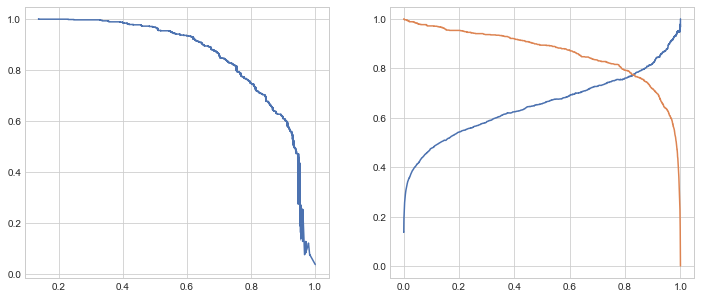

In [745]:
model_cat = catb.CatBoostClassifier(loss_function='Logloss',
                                verbose=True,
                                scale_pos_weight=20,
                                thread_count=20,
                                max_depth=4, 
                                learning_rate=0.1, 
                                n_estimators=1000,
                                reg_lambda=10,
                                   random_state=42)

df_ERA_feature_importances = fit_clf_on_all_features(model_cat, df_ERA_all_features, feature_names)

In [18]:
# Fit a global classifier on all features
model_xg = xgb.XGBClassifier(
                    max_depth=3,
                    learning_rate=0.1,
                    gamma=0.0,
                    min_child_weight=0.0,
                    max_delta_step=0.0,
                    subsample=1.0,
                    colsample_bytree=1.0,
                    colsample_bylevel=1.0,
                    reg_alpha=100.0,
                    reg_lambda=1.0,
                    n_estimators=100,
                    verbosity=2,
                    nthread=20,
                    scale_pos_weight=20.0,
                    base_score=0.2,
                    seed=1337,
                    missing=None,
                  )
df_ERA_feature_importances = fit_clf_on_all_features(model_xg)

[15:26:00] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:26:01] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:26:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:26:04] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:26:06] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:26:08] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:26:10] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:26:11] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:26:14] INFO: /workspace/src/tree/upd

[15:27:46] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:27:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:27:49] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:27:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:27:52] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:27:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:27:55] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:27:56] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:27:58] INFO: /workspace/src/tree/upd

XGBClassifier(base_score=0.2, booster='gbtree', colsample_bylevel=1.0,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0.0, max_depth=3,
              min_child_weight=0.0, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=20, nthread=20, num_parallel_tree=1,
              random_state=1337, reg_alpha=100.0, reg_lambda=1.0,
              scale_pos_weight=20.0, seed=1337, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=2)

# Reduce dataframe to most important features

In [765]:
df_ERA_reduced_features = df_ERA_all_features.loc[:,df_ERA_feature_importances.loc[:100, "feature_name"]]
feature_names_reduced = df_ERA_reduced_features.columns.tolist()
df_ERA_reduced_features["date"] = df_ERA_all_features["date"]
df_ERA_reduced_features["Foehn"] = df_ERA_all_features["Foehn"]

# Transform features to quantiles on ERA

In [766]:
quantile_scaler_ERA = QuantileTransformer(subsample=10**(6), random_state=42)
quantile_scaler_ERA.fit(df_ERA_reduced_features.loc[train_mask, feature_names_reduced]) # Only fit on training data

df_ERA_reduced_features_scaled = pd.DataFrame(quantile_scaler_ERA.transform(df_ERA_reduced_features.loc[:, feature_names_reduced]), 
                                              columns = feature_names_reduced, 
                                              index=df_ERA_reduced_features.index)
df_ERA_reduced_features_scaled["date"] = df_ERA_all_features["date"]
df_ERA_reduced_features_scaled["Foehn"] = df_ERA_all_features["Foehn"]

# PCA

[0.48762378 0.13282685 0.0751873  0.05344011 0.03934059 0.03784379
 0.02396503 0.01829789 0.01613884 0.01467512]


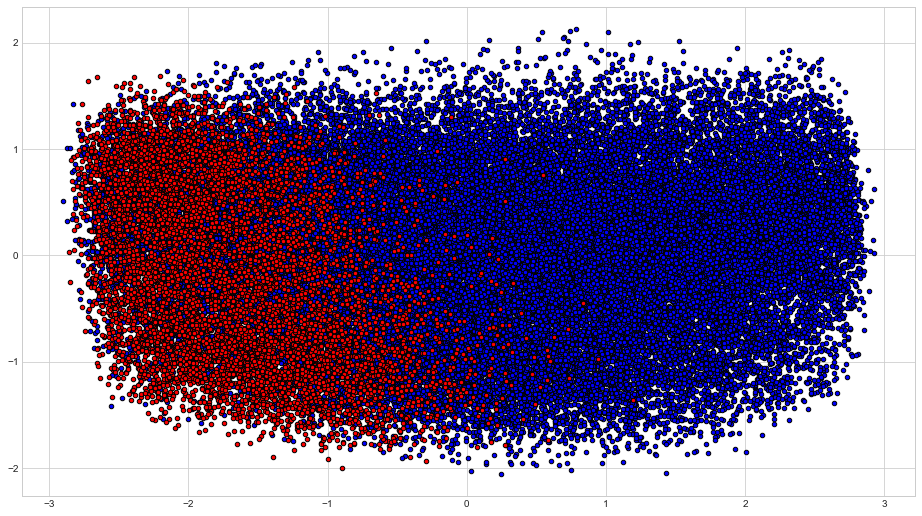

In [210]:
pca = sklearn.decomposition.PCA(n_components=10)
pca.fit(df_ERA_reduced_features_scaled.loc[train_mask, feature_names_reduced])

print(pca.explained_variance_ratio_)

samples_PCA_transformed = pca.transform(df_ERA_reduced_features_scaled.loc[:, feature_names_reduced])
#samples_CESMp_PCA_transformed = pca.transform(df_CESMp_reduced_features_scaled.loc[:, feature_names_reduced])

component_1 =0
component_2 =1
plt.figure(figsize=(16,9))

plt.scatter(samples_PCA_transformed[df_ERA_reduced_features_scaled.loc[:, "Foehn"]==0, component_1 ], 
            samples_PCA_transformed[df_ERA_reduced_features_scaled.loc[:, "Foehn"]==0, component_2 ], 
            c="blue",
            s=20, 
            edgecolor='k')

plt.scatter(samples_PCA_transformed[df_ERA_reduced_features_scaled.loc[:, "Foehn"]==1, component_1 ], 
            samples_PCA_transformed[df_ERA_reduced_features_scaled.loc[:, "Foehn"]==1, component_2 ], 
            c="red",
            s=20, 
            edgecolor='k')

# plt.figure(figsize=(16,9))

# plt.scatter(samples_CESMp_PCA_transformed[df_CESMp_reduced_features_scaled.loc[:, "prediction"]==0, component_1 ], 
#             samples_CESMp_PCA_transformed[df_CESMp_reduced_features_scaled.loc[:, "prediction"]==0, component_2 ], 
#             c="blue",
#             s=20, 
#             edgecolor='k')

# plt.scatter(samples_CESMp_PCA_transformed[df_CESMp_reduced_features_scaled.loc[:, "prediction"]==1, component_1 ], 
#             samples_CESMp_PCA_transformed[df_CESMp_reduced_features_scaled.loc[:, "prediction"]==1, component_2 ], 
#             c="red",
#             s=20, 
#             edgecolor='k')








Best threshold: 0.41433385152286095
Precision: 0.6717670286278381
Recall: 0.6714356191415886
[[11919   665]
 [  666  1361]]


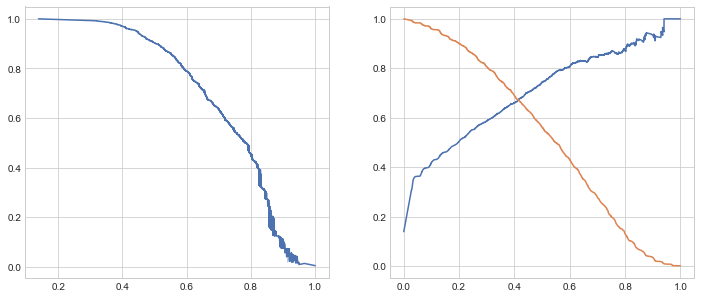

In [211]:
model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=30, n_jobs=25, weights="distance")

model.fit(samples_PCA_transformed[train_mask, :], df_ERA_reduced_features_scaled.loc[train_mask, "Foehn"])

predictions = model.predict_proba(samples_PCA_transformed[test_mask, :])

precisions, recalls, thresholds = precision_recall_curve(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], predictions[:,1])
best_threshold_ERA = thresholds[np.argmin(abs(precisions-recalls))]
predictions = (predictions[:,1]>best_threshold_ERA).astype(int)

# Plot model evaluation curves
f = plt.figure(figsize=(12,5))
f.add_subplot(121)
sns.lineplot(precisions, recalls)
f.add_subplot(122)
sns.lineplot(np.append(thresholds, 1.0), precisions)
sns.lineplot(np.append(thresholds, 1.0), recalls)

# Print model evaluation scores
print(f"Best threshold: {best_threshold_ERA}")
print(f'Precision: {precision_score(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], predictions)}')
print(f'Recall: {recall_score(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], predictions)}')
print(confusion_matrix(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], predictions))

# Fit XGBoost to reduced feature set & evaluate

In [581]:
def plot_metrics_by_month(precision_scores, recall_scores, f1_scores):
    plt.figure(figsize=(16,9))
    plt.plot(MONTH_NAMES, precision_scores)
    plt.plot(MONTH_NAMES, recall_scores)
    plt.plot(MONTH_NAMES, f1_scores)
    plt.legend(["precision", "recall", "f1-score"])

In [582]:
def get_best_model_through_CV(model, parameters_CV):
    # Fit model
    model_CV = GridSearchCV(model, parameters_CV, cv=3, n_jobs=5, scoring='neg_log_loss')
    model_CV.fit(df_ERA_reduced_features_scaled.loc[train_mask, feature_names_reduced], 
                 df_ERA_reduced_features_scaled.loc[train_mask, "Foehn"])
    print(model_CV.best_params_)
    
    # Predict and optimize threshold
    best_model = model_CV.best_estimator_
    df_ERA_reduced_features_scaled.loc[:, "prediction_proba"] = best_model.predict_proba(df_ERA_reduced_features_scaled.loc[:, feature_names_reduced])[:,1]
    precisions, recalls, thresholds = precision_recall_curve(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], 
                                                             df_ERA_reduced_features_scaled.loc[test_mask, "prediction_proba"])
    best_threshold_ERA = thresholds[np.argmin(abs(precisions-recalls))]
    df_ERA_reduced_features_scaled.loc[:, "prediction"] = (df_ERA_reduced_features_scaled.loc[:, "prediction_proba"]> best_threshold_ERA).astype(int)
    
    # Plot model evaluation curves
#     f = plt.figure(figsize=(12,5))
#     f.add_subplot(121)
#     sns.lineplot(precisions, recalls)
#     f.add_subplot(122)
#     sns.lineplot(np.append(thresholds, 1.0), precisions)
#     sns.lineplot(np.append(thresholds, 1.0), recalls)
    
    # Print model evaluation scores
    
    df_ERA_reduced_features_scaled.loc[test_mask, "prediction"]
    print(f"Best threshold: {best_threshold_ERA}")
    print(f'Precision: {precision_score(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask, "prediction"])}')
    print(f'Recall: {recall_score(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask, "prediction"])}')
    print(confusion_matrix(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask, "prediction"]))
    display(pd.DataFrame({"feature_name": feature_names_reduced, "importance": best_model.feature_importances_}).sort_values(by="importance", ascending=False).reset_index(drop=True).head(10))
    
    precision_scores, recall_scores, f1_scores = [], [], []
    for month in range(1,12+1):
        test_mask_month =  test_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
        precision = precision_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        recall = recall_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        f1score = f1_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1score)

    plot_metrics_by_month(precision_scores, recall_scores, f1_scores)
    
   
    return best_model, best_threshold_ERA

In [583]:
from sklearn.model_selection import cross_validate

def train_model_for_each_month(model, parameters):
    models_retrained_list, thresholds_list = [], []
    
    precision_scores, recall_scores, f1_scores = [], [], []
    
    plt.figure(figsize=(16,9))
    for month in range(1,12+1):
        # Define train and test masks
        train_mask_month = train_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
        test_mask_month =  test_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
        all_mask_month =  (df_ERA_reduced_features_scaled["date"].dt.month == month)
        
        # CV
#         model.set_params(scale_pos_weight=df_ERA_reduced_features_scaled.loc[train_mask_month, "Foehn"].count()/df_ERA_reduced_features_scaled.loc[train_mask_month, "Foehn"].sum())
#         print(model.get_params())
        model_CV = GridSearchCV(model, parameters, cv=[(slice(None), slice(None))], n_jobs=4, scoring=custom_metric_for_month, verbose=1)
        model_CV.fit(df_ERA_reduced_features_scaled.loc[train_mask_month, feature_names_reduced], 
                     df_ERA_reduced_features_scaled.loc[train_mask_month, "Foehn"])
        print(model_CV.cv_results_["mean_test_score"])
        # Get feature importance
#         print(dict(zip(feature_names_reduced, model_CV.best_estimator_.feature_importances_)))
        
        # Optimize threshold
        best_model = model_CV.best_estimator_
        df_ERA_reduced_features_scaled.loc[all_mask_month, "prediction_proba"] = best_model.predict_proba(df_ERA_reduced_features_scaled.loc[all_mask_month, feature_names_reduced])[:,1]
        precisions, recalls, thresholds = precision_recall_curve(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], 
                                                                 df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction_proba"])
        best_threshold_ERA = thresholds[np.argmin(abs(precisions-recalls))]
        df_ERA_reduced_features_scaled.loc[all_mask_month, "prediction"] = (df_ERA_reduced_features_scaled.loc[all_mask_month, "prediction_proba"]>best_threshold_ERA).astype(int)
        
        # Print model evaluation scores
        precision = precision_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        recall = recall_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        f1score = f1_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1score)
        
        print(f"Best threshold: {best_threshold_ERA}")
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(confusion_matrix(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"]))
        display(pd.DataFrame({"feature_name": feature_names_reduced, "importance": best_model.feature_importances_}).sort_values(by="importance", ascending=False).reset_index(drop=True).head(10))
        
        # Retrain model on full data
        best_model.fit(df_ERA_reduced_features_scaled.loc[all_mask_month, feature_names_reduced], 
                       df_ERA_reduced_features_scaled.loc[all_mask_month, "Foehn"])
        models_retrained_list.append(best_model)
        thresholds_list.append(best_threshold_ERA)
        
    plot_metrics_by_month(precision_scores, recall_scores, f1_scores)
    return models_retrained_list, thresholds_list

In [839]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# from sklearn.metrics import log_loss, make_scorer
def custom_loss(predt: np.ndarray, dtrain: xgb.DMatrix, ERA_len, CESM_len, alpha=0.0001):
    y = dtrain.get_label()[:ERA_len]
    
    pred = sigmoid(predt)
    pred_ERA = pred[:ERA_len]
    pred_CESM = pred[ERA_len:]
    
    grad_logloss  = pred_ERA - y
    hess_logloss = pred_ERA*(1.0 - pred_ERA)

    
#     grad = () + 2*alpha/CESM_len*(np.mean(predt) - np.mean(y))
    
    grad_custom = 2*alpha/CESM_len*pred_CESM*(1-pred_CESM)*(np.mean(pred_CESM)-np.mean(y))
    hess_custom = 2*alpha/CESM_len*pred_CESM*(1-pred_CESM)*((1-pred_CESM)*(np.mean(pred_CESM)-np.mean(y)) -
                                                            pred_CESM*(np.mean(pred_CESM)-np.mean(y)) +
                                                            pred_CESM*(1-pred_CESM)/CESM_len
                                                            )
    
    grad = np.zeros(len(predt))
    grad[:ERA_len] = grad_logloss
    grad[ERA_len:] = grad_custom
    
    hess = np.zeros(len(predt))
    hess[:ERA_len] = hess_logloss
    hess[ERA_len:] = hess_custom
    
    return grad, hess

def custom_metric_for_month(estimator, X, y):
    month_mask_ERA_custom_metric = (df_ERA_reduced_features_scaled["date"].dt.month == month)
    month_mask_CESMp_custom_metric = (df_CESMp_reduced_features_scaled["date"].dt.month == month)
    
    prediction_probas_ERA = estimator.predict_proba(X)[:,1]
    precisions, recalls, thresholds = precision_recall_curve(y, prediction_probas_ERA)
    best_threshold_ERA = thresholds[np.argmin(abs(precisions-recalls))]                                                         
    
    foehn_truth = df_ERA_reduced_features_scaled.loc[month_mask_ERA_custom_metric, "Foehn"]
    CESMp_predictions = (estimator.predict_proba(df_CESMp_reduced_features_scaled.loc[month_mask_CESMp_custom_metric, feature_names_reduced]) >best_threshold_ERA).astype(int)
    
    
    
    
    return -np.square(np.mean(CESMp_predictions)-np.mean(foehn_truth))

In [840]:
monthly_models = 1
estimator = "XGB" # XGB, CATB, LGB, or KNN

## XGBoost estimator
if estimator == "XGB":
#     model = xgb.XGBClassifier(
#                     gamma=0.0,
#                     min_child_weight=0.0,
#                     max_delta_step=0.0,
#                     subsample=1.0,
#                     colsample_bytree=1.0,
#                     colsample_bylevel=1.0,
#                     verbosity=3,
#                     nthread=5,
#                     scale_pos_weight=20.0,
#                     base_score=0.2,
#                     seed=1337,
#                     missing=None,
#                     objective=custom_loss
#                   )
    parameters = {'max_depth': [3], 'learning_rate': [0.1], 'n_estimators':[30], "reg_alpha":[10], "reg_lambda":[10] }
    params = {'max_depth': 4, 'learning_rate': 0.1, "reg_alpha":10, "reg_lambda":10, "nthreads": 30, "verbosity":0, "seed": 0}
    
    models_retrained_list, thresholds_list = [], []
    for month in range(1,12+1):
        train_mask_month = train_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
        test_mask_month = test_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
        month_mask_CESMp = (df_CESMp_reduced_features_scaled["date"].dt.month == month)
        
        df_ERA_CESMp = pd.concat([df_ERA_reduced_features_scaled.loc[train_mask_month, feature_names_reduced + ["Foehn"]], 
                                  df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, feature_names_reduced]],
                                axis=0)
        print(len(df_ERA_CESMp))
        
        D_train = xgb.DMatrix(df_ERA_CESMp[feature_names_reduced],
                             label=df_ERA_CESMp["Foehn"])
        model = xgb.Booster(params, [D_train])
        
        for _ in range(200):
            pred = model.predict(D_train)
            g, h = custom_loss(pred, D_train, ERA_len=train_mask_month.sum(), CESM_len = month_mask_CESMp.sum())
            model.boost(D_train, g, h)
        
        D_test = xgb.DMatrix(df_ERA_reduced_features_scaled.loc[test_mask_month, feature_names_reduced])
        yhat = sigmoid(model.predict(D_test))
        print(yhat)
        df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction_proba"] = sigmoid(model.predict(D_test))
        precisions, recalls, thresholds = precision_recall_curve(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], 
                                                                 df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction_proba"])
        best_threshold_ERA = thresholds[np.argmin(abs(precisions-recalls))]
        df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"] = (df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction_proba"]>best_threshold_ERA).astype(int)
        
        # Print model evaluation scores
        precision = precision_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        recall = recall_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
        f1score = f1_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
#         precision_scores.append(precision)
#         recall_scores.append(recall)
#         f1_scores.append(f1score)
        
        print(f"Best threshold: {best_threshold_ERA}")
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(confusion_matrix(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"]))
#         print(model.get_score(importance_type='weight'))
        display(pd.DataFrame.from_dict(model.get_score(importance_type='weight'), orient="index", columns=["importance"]).sort_values(by="importance", ascending=False).head(10))
        
        
#         precisions, recalls, thresholds = precision_recall_curve(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], 
#                                                                  yhat)
#         best_threshold_ERA = thresholds[np.argmin(abs(precisions-recalls))]
# #         df_ERA_reduced_features_scaled.loc[:, "prediction"] = (df_ERA_reduced_features_scaled.loc[:, "prediction_proba"]> best_threshold_ERA).astype(int)
    
# #         Plot model evaluation curves
#         f = plt.figure(figsize=(12,5))
#         f.add_subplot(121)
#         sns.lineplot(precisions, recalls)
#         f.add_subplot(122)
#         sns.lineplot(np.append(thresholds, 1.0), precisions)
#         sns.lineplot(np.append(thresholds, 1.0), recalls)
        
        models_retrained_list.append(model)
        thresholds_list.append(best_threshold_ERA)
        


    
## CatBoost estimator
elif estimator == "CGB":
    model = catb.CatBoostClassifier(loss_function='Logloss',
                                    verbose=False,
                                    scale_pos_weight=20,
                                    thread_count=5,
                                    random_seed=42)

    parameters = {'max_depth': [1,2,3,4, 5], 'learning_rate': [0.1], 'n_estimators':[10,20,30, 40,50, 100]}

## LightGBM estimator
elif estimator == "LGB":
    model = lgb.LGBMClassifier(loss_function='Logloss',
                               boosting_type="goss",
                                    verbose=0,
                                    scale_pos_weight=20,
                                    n_jobs=5,
                                    random_seed=42)

    parameters = {'max_depth': [1,2,3,4, 5], 'learning_rate': [0.1], 'n_estimators':[10,20,30, 40,50, 100]}

## KNN estimator
elif estimator == "KNN": 
    model = sklearn.neighbors.KNeighborsClassifier(n_jobs=8,weights="distance")
    parameters = {'n_neighbors': [30,50]}
elif estimator=="LR":
    model = sklearn.linear_model.LogisticRegression(random_state=42,class_weight={0:1, 1:20}, max_iter=500, n_jobs=30, penalty="l1", solver="saga")
    parameters= {"C":[0.1]}

# Monthly or yearly model
# if monthly_models:
#     models_retrained_list, thresholds_list = train_model_for_each_month(model, parameters)
# else:
#     model, best_threshold_ERA = get_best_model_through_CV(model, parameters)
#     model.set_params(n_jobs=25)
    
df_ERA_reduced_features_scaled["dataset"] = "ERA"
df_ERA_reduced_features_scaled["ensemble"] = "ERA"


46769
[0.00217604 0.00198874 0.00198874 ... 0.00181034 0.00200537 0.00176054]
Best threshold: 0.41886743903160095
Precision: 0.71875
Recall: 0.7076923076923077
[[1146   18]
 [  19   46]]


,importance
diff_PHIT_4853_1125_850_PHIT_4947_1125_850,37
diff_PHIT_4382_1000_850_PHIT_4570_1375_850,29
diff_SLP_4476_875_sealevel_SLP_4853_500_sealevel,27
diff_Z_4382_750_850_Z_4476_1125_850,26
diff_PHIT_4570_1375_850_PHIT_4853_1125_850,24
diff_Z_4476_1125_850_Z_4853_750_850,23
DELTAPHI_4853_875_700,22
diff_Z_4287_1250_700_Z_4382_1125_700,22
U_4287_500_850,22
DELTAPHI_4853_750_700,22


42285
[0.00247445 0.00534903 0.00609105 ... 0.02358085 0.280665   0.3241749 ]
Best threshold: 0.3090646266937256
Precision: 0.8135593220338984
Recall: 0.8
[[1059   11]
 [  12   48]]


,importance
diff_PHIT_4476_875_850_PHIT_4853_1000_850,55
DELTAPHI_4853_1000_700,30
diff_PHIT_4853_500_850_PHIT_4853_625_850,28
diff_SLP_4476_750_sealevel_SLP_4853_875_sealevel,25
diff_SLP_4570_1375_sealevel_SLP_4853_875_sealevel,22
diff_SLP_4664_1375_sealevel_SLP_4853_875_sealevel,21
diff_PHIT_4664_1375_850_PHIT_4853_1000_850,21
diff_PHIT_4382_1250_850_PHIT_4476_875_850,19
diff_SLP_4853_1000_sealevel_SLP_4853_875_sealevel,17
diff_Z_4476_1125_850_Z_4570_375_850,17


46820
[0.07588588 0.05693049 0.04262722 ... 0.00218815 0.00685059 0.00811853]
Best threshold: 0.4910372197628021
Precision: 0.7543859649122807
Recall: 0.7413793103448276
[[1160   14]
 [  15   43]]


,importance
DELTAPHI_4853_1000_700,69
diff_PHIT_4476_875_850_PHIT_4853_1000_850,42
diff_PHIT_4853_750_850_PHIT_4947_750_850,39
diff_Z_4287_375_850_Z_4476_875_850,30
diff_PHIT_4287_375_850_PHIT_4853_1000_850,29
diff_Z_4853_1500_850_Z_4853_875_850,29
DELTAPHI_4853_875_700,23
diff_PHIT_4570_1375_850_PHIT_4853_1125_850,23
U_4287_500_850,19
diff_SLP_4759_1375_sealevel_SLP_4853_1000_sealevel,19


45203
[0.00266327 0.00193214 0.00200952 ... 0.00551928 0.00519466 0.00460309]
Best threshold: 0.4818255603313446
Precision: 0.8321167883211679
Recall: 0.8260869565217391
[[1035   23]
 [  24  114]]


,importance
diff_PHIT_4853_1000_850_PHIT_4947_1000_850,53
DELTAPHI_4853_1000_700,41
diff_SLP_4570_1375_sealevel_SLP_4853_875_sealevel,40
DELTAPHI_4853_875_700,40
DELTAPHI_4853_750_700,29
diff_Z_4287_375_850_Z_4476_875_850,28
diff_SLP_4476_750_sealevel_SLP_4853_875_sealevel,27
Z_4947_1000_500,26
U_4287_500_850,26
diff_SLP_4664_1375_sealevel_SLP_4853_875_sealevel,26


46797
[0.01074755 0.01056509 0.005154   ... 0.00314136 0.00179258 0.00195268]
Best threshold: 0.3835906684398651
Precision: 0.7064220183486238
Recall: 0.7
[[1092   32]
 [  33   77]]


,importance
DELTAPHI_4853_875_700,32
diff_PHIT_4853_750_850_PHIT_4947_750_850,31
diff_SLP_4476_750_sealevel_SLP_4853_875_sealevel,29
diff_PHIT_4382_1250_850_PHIT_4476_875_850,29
DELTAPHI_4853_750_700,29
diff_PHIT_4570_1375_850_PHIT_4853_1125_850,28
diff_PHIT_4476_625_850_PHIT_4476_750_850,26
DELTAPHI_4853_1000_700,26
diff_Z_4287_0_700_Z_4853_875_700,26
diff_PHIT_4853_1000_850_PHIT_4947_1000_850,24


45352
[0.002194   0.00227798 0.00225282 ... 0.00225282 0.00625002 0.00238507]
Best threshold: 0.4044274389743805
Precision: 0.6410256410256411
Recall: 0.625
[[1143   14]
 [  15   25]]


,importance
DELTAPHI_4853_875_700,30
V_4664_1375_700,28
diff_Z_4476_750_850_Z_4476_875_850,24
diff_PHIT_4476_875_850_PHIT_4853_1000_850,24
diff_PHIT_4287_375_850_PHIT_4853_1000_850,23
Z_4947_1000_500,22
DELTAPHI_4476_1250_700,21
diff_PHIT_4476_750_850_PHIT_4853_1000_850,20
diff_SLP_4476_1125_sealevel_SLP_4853_875_sealevel,17
diff_PHIT_4570_1375_850_PHIT_4853_1125_850,17


46843
[0.00225958 0.00225958 0.00225958 ... 0.0021779  0.0021779  0.0021779 ]
Best threshold: 0.4409712255001068
Precision: 0.5384615384615384
Recall: 0.5
[[1206    6]
 [   7    7]]


,importance
diff_PHIT_4853_500_850_PHIT_4853_625_850,52
DELTAPHI_4853_1000_700,31
diff_SLP_4664_1375_sealevel_SLP_4853_875_sealevel,30
diff_PHIT_4287_375_850_PHIT_4853_1000_850,29
diff_Z_4853_875_850_Z_4947_1375_850,27
diff_PHIT_4476_750_850_PHIT_4853_1000_850,23
diff_Z_4476_1000_850_Z_4476_625_850,22
diff_SLP_4476_750_sealevel_SLP_4853_875_sealevel,22
DELTAPHI_4382_750_850,21
diff_SLP_4853_1000_sealevel_SLP_4853_875_sealevel,19


46804
[0.00206533 0.00206533 0.00206533 ... 0.00213707 0.00227778 0.00206533]
Best threshold: 0.2736068069934845
Precision: 0.5909090909090909
Recall: 0.5652173913043478
[[1207    9]
 [  10   13]]


,importance
diff_PHIT_4853_500_850_PHIT_4853_625_850,37
DELTAPHI_4853_875_700,33
diff_Z_4853_0_700_Z_4947_1125_700,28
diff_Z_4382_750_850_Z_4476_1125_850,24
diff_Z_4853_875_850_Z_4947_1375_850,23
diff_Z_4382_875_850_Z_4570_125_850,23
diff_SLP_4759_1375_sealevel_SLP_4853_1000_sealevel,20
diff_Z_4853_1500_850_Z_4853_875_850,19
DELTAPHI_4853_625_850,17
DELTAPHI_4476_1125_700,16


45317
[0.00618236 0.01075059 0.00700623 ... 0.02054716 0.01056274 0.00748324]
Best threshold: 0.3018691837787628
Precision: 0.7096774193548387
Recall: 0.6984126984126984
[[1117   18]
 [  19   44]]


,importance
DELTAPHI_4853_875_700,66
diff_Z_4287_375_850_Z_4476_875_850,56
diff_PHIT_4853_500_850_PHIT_4853_625_850,39
diff_PHIT_4570_1375_850_PHIT_4853_1125_850,36
diff_PHIT_4853_750_850_PHIT_4947_750_850,32
DELTAPHI_4853_750_700,28
SLP_4382_0_sealevel,27
diff_PHIT_4853_1125_850_PHIT_4947_1125_850,27
diff_Z_4476_500_850_Z_4476_875_850,19
diff_Z_4476_750_850_Z_4476_875_850,15


46830
[0.00305276 0.00253864 0.0026618  ... 0.06632688 0.01466138 0.00242508]
Best threshold: 0.4611457288265228
Precision: 0.782608695652174
Recall: 0.7714285714285715
[[1149   15]
 [  16   54]]


,importance
DELTAPHI_4853_1000_700,40
diff_PHIT_4853_1125_850_PHIT_4947_1125_850,25
diff_PHIT_4382_1250_850_PHIT_4476_875_850,23
diff_Z_4476_500_850_Z_4476_875_850,22
diff_Z_4570_1375_850_Z_4853_875_850,22
diff_PHIT_4853_500_850_PHIT_4853_625_850,21
U_4476_500_850,20
diff_Z_4476_750_850_Z_4476_875_850,20
diff_Z_4476_1000_850_Z_4476_125_850,20
diff_PHIT_4664_1375_850_PHIT_4853_1000_850,20


45306
[0.00331164 0.00504556 0.00881968 ... 0.00247456 0.00405141 0.01778107]
Best threshold: 0.6066867709159851
Precision: 0.7794117647058824
Recall: 0.7681159420289855
[[1105   15]
 [  16   53]]


,importance
DELTAPHI_4853_875_700,33
diff_PHIT_4853_500_850_PHIT_4853_625_850,32
U_4476_500_850,29
diff_PHIT_4476_750_850_PHIT_4853_1000_850,27
diff_Z_4287_750_850_Z_4382_1375_850,26
diff_Z_4382_500_850_Z_4476_1000_850,24
DELTAPHI_4476_1500_850,24
DELTAPHI_4476_1250_850,24
diff_SLP_4476_750_sealevel_SLP_4853_875_sealevel,23
DELTAPHI_4287_1500_850,19


46792
[0.00728122 0.00902827 0.00538925 ... 0.00215652 0.00210984 0.00256197]
Best threshold: 0.4093008041381836
Precision: 0.7627118644067796
Recall: 0.75
[[1158   14]
 [  15   45]]


,importance
diff_PHIT_4476_625_850_PHIT_4476_750_850,30
V_4476_1125_700,28
diff_Z_4476_1500_850_Z_4664_375_850,25
diff_Z_4476_1125_850_Z_4570_375_850,21
diff_PHIT_4664_1375_850_PHIT_4853_1000_850,21
diff_Z_4476_500_850_Z_4476_875_850,21
diff_SLP_4664_1375_sealevel_SLP_4853_875_sealevel,20
diff_Z_4287_1250_700_Z_4382_1125_700,20
diff_PHIT_4382_1250_850_PHIT_4853_1000_850,19
diff_Z_4570_1375_850_Z_4853_875_850,18


# Load CESM data 

In [39]:
df_CESMp = pd.read_csv("/net/litho/atmosdyn2/chmony/data/MeteorologicalData/CESM_present_day.csv.gz")
df_CESMp["date"] = pd.to_datetime(df_CESMp["date"], format="%Y-%m-%dT%H:%M:00.000000Z") # Due to Dataiku date format

In [40]:
df_CESMf = pd.read_csv("/net/litho/atmosdyn2/chmony/data/MeteorologicalData/CESM_future_day.csv.gz")
df_CESMf["date"] = pd.to_datetime(df_CESMf["date"], format="%Y-%m-%dT%H:%M:00.000000Z") # Due to Dataiku date format

In [41]:
# Create pot. temp features for CESMp
df_T= df_CESMp.filter(regex=("T\w+900")).add_prefix("PHI")
df_PHIT_900 = calc_pot_temp(T=df_T, p = 900.0)
df_T= df_CESMp.filter(regex=("T\w+850")).add_prefix("PHI")
df_PHIT_850 = calc_pot_temp(T=df_T, p = 850.0)
df_T= df_CESMp.filter(regex=("T\w+700")).add_prefix("PHI")
df_PHIT_700 = calc_pot_temp(T=df_T, p = 700.0)
df_CESMp = pd.concat([df_CESMp, df_PHIT_900, df_PHIT_850, df_PHIT_700], axis=1)

# Create pot. temp features for CESMf
df_T= df_CESMf.filter(regex=("T\w+900")).add_prefix("PHI")
df_PHIT_900 = calc_pot_temp(T=df_T, p = 900.0)
df_T= df_CESMf.filter(regex=("T\w+850")).add_prefix("PHI")
df_PHIT_850 = calc_pot_temp(T=df_T, p = 850.0)
df_T= df_CESMf.filter(regex=("T\w+700")).add_prefix("PHI")
df_PHIT_700 = calc_pot_temp(T=df_T, p = 700.0)
df_CESMf = pd.concat([df_CESMf, df_PHIT_900, df_PHIT_850, df_PHIT_700], axis=1)

del df_PHIT_900, df_PHIT_850, df_PHIT_700

In [767]:
# Create features which are used by the simplified model
feature_dict_CESMp = {}
feature_dict_CESMf = {}
for feature_name in feature_names_reduced:
    if feature_name[0:6] == "diff_S":
        feature_name_splitted = feature_name.split("_")
        first_feature = "_".join(feature_name_splitted[1:5])
        second_feature = "_".join(feature_name_splitted[5:9])
        
        feature_dict_CESMp[f"diff_{first_feature}_{second_feature}"] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf[f"diff_{first_feature}_{second_feature}"] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values

    elif feature_name[0:6] == "diff_Z":
        feature_name_splitted = feature_name.split("_")
        first_feature = "_".join(feature_name_splitted[1:5])
        second_feature = "_".join(feature_name_splitted[5:9])
        
        feature_dict_CESMp[f"diff_{first_feature}_{second_feature}"] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf[f"diff_{first_feature}_{second_feature}"] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values

    elif feature_name[0:6] == "diff_P":
        feature_name_splitted = feature_name.split("_")
        first_feature = "_".join(feature_name_splitted[1:5])
        second_feature = "_".join(feature_name_splitted[5:9])
        
        feature_dict_CESMp[f"diff_{first_feature}_{second_feature}"] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf[f"diff_{first_feature}_{second_feature}"] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values

    elif feature_name[0:6] == "DELTAP":
        feature_name_splitted = feature_name.split("_")
        first_feature = "PHIT_" + "_".join(feature_name_splitted[1:4])
        second_feature = "PHIT_" + "_".join(feature_name_splitted[1:3]) + "_900"
        
        feature_dict_CESMp["DELTAPHI_" +"_".join(feature_name_splitted[1:4])] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf["DELTAPHI_" +"_".join(feature_name_splitted[1:4])] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values
    
    else:
        feature_dict_CESMp[feature_name] = df_CESMp.loc[:, feature_name].values
        feature_dict_CESMf[feature_name] = df_CESMf.loc[:, feature_name].values

feature_dict_CESMp["date"] =df_CESMp.loc[:, "date"].values
feature_dict_CESMf["date"] =df_CESMf.loc[:, "date"].values

feature_dict_CESMp["ensemble"] =df_CESMp.loc[:, "ensemble"].values
feature_dict_CESMf["ensemble"] =df_CESMf.loc[:, "ensemble"].values

df_CESMp_reduced_features = pd.DataFrame(feature_dict_CESMp)
df_CESMf_reduced_features = pd.DataFrame(feature_dict_CESMf)

# Transform features to quantiles on CESM

In [785]:
quantile_scaler_CESM = QuantileTransformer(subsample=10**(6), random_state=42)
quantile_scaler_CESM.fit(df_CESMp_reduced_features.loc[:, feature_names_reduced])

df_CESMp_reduced_features_scaled = pd.DataFrame(quantile_scaler_CESM.transform(df_CESMp_reduced_features.loc[:, feature_names_reduced]), 
                                                columns = feature_names_reduced, 
                                                index=df_CESMp_reduced_features.loc[:, feature_names_reduced].index)

df_CESMf_reduced_features_scaled = pd.DataFrame(quantile_scaler_CESM.transform(df_CESMf_reduced_features.loc[:, feature_names_reduced]), 
                                                columns = feature_names_reduced, 
                                                index=df_CESMf_reduced_features.loc[:, feature_names_reduced].index)

df_CESMp_reduced_features_scaled["date"] = df_CESMp_reduced_features["date"]
df_CESMf_reduced_features_scaled["date"] = df_CESMf_reduced_features["date"]

df_CESMp_reduced_features_scaled["ensemble"] = df_CESMp_reduced_features["ensemble"]
df_CESMf_reduced_features_scaled["ensemble"] = df_CESMf_reduced_features["ensemble"]

# Predict on CESMp and CESMf

In [841]:
if monthly_models:
    for month in range(1,12+1):
        month_mask_CESMp = (df_CESMp_reduced_features_scaled["date"].dt.month == month )
        month_mask_CESMf = (df_CESMf_reduced_features_scaled["date"].dt.month == month )
        
        xgb_CESMp = xgb.DMatrix(df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, feature_names_reduced])
        df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, "prediction_proba"] = sigmoid(models_retrained_list[month-1].predict(xgb_CESMp))
        df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, "prediction"] = (df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, "prediction_proba"]> thresholds_list[month-1]).astype(int)
        
        xgb_CESMf = xgb.DMatrix(df_CESMf_reduced_features_scaled.loc[month_mask_CESMf, feature_names_reduced])
        df_CESMf_reduced_features_scaled.loc[month_mask_CESMf, "prediction_proba"] = sigmoid(models_retrained_list[month-1].predict(xgb_CESMf))
        df_CESMf_reduced_features_scaled.loc[month_mask_CESMf, "prediction"] = (df_CESMf_reduced_features_scaled.loc[month_mask_CESMf, "prediction_proba"]> thresholds_list[month-1]).astype(int)
                                                 
else:
    df_CESMp_reduced_features_scaled["prediction_proba"] = model.predict_proba(df_CESMp_reduced_features_scaled.loc[:, feature_names_reduced])[:,1]
    df_CESMp_reduced_features_scaled["prediction"] = (df_CESMp_reduced_features_scaled["prediction_proba"]> best_threshold_ERA).astype(int)
    df_CESMf_reduced_features_scaled["prediction_proba"] = model.predict_proba(df_CESMf_reduced_features_scaled.loc[:, feature_names_reduced])[:,1]
    df_CESMf_reduced_features_scaled["prediction"] = (df_CESMf_reduced_features_scaled["prediction_proba"]> best_threshold_ERA).astype(int)

df_CESMp_reduced_features_scaled["dataset"] = "CESMp"
df_CESMf_reduced_features_scaled["dataset"] = "CESMf"

# Playing with relabeling CESMp

In [409]:
# new_labels_CESMp = pd.Series(np.NaN, index=df_CESMp_reduced_features_scaled.index)
# new_labels_CESMp = new_labels_CESMp.mask(df_CESMp_reduced_features_scaled["prediction_proba"]>0.95, 1)
# new_labels_CESMp = new_labels_CESMp.mask(df_CESMp_reduced_features_scaled["prediction_proba"]<0.05, 0)
# new_labels_CESMp.value_counts(dropna=False)

0.0    426339
NaN     60839
1.0     23822
dtype: int64

In [410]:
# def get_best_model_through_CV(model, parameters_CV, df, feature_names, target_variable="Foehn"):
#     # Define train and test masks
#     year_split = 1999
#     train_mask = (df["date"].dt.year < year_split) & (df[target_variable].notnull())
#     test_mask = (df["date"].dt.year >= year_split) & (df[target_variable].notnull())
    
#     # Fit model
#     model_CV = GridSearchCV(model, parameters_CV, cv=3, n_jobs=5, scoring='neg_log_loss')
#     model_CV.fit(df.loc[train_mask, feature_names], 
#                  df.loc[train_mask, target_variable])
#     print(model_CV.best_params_)
    
#     # Predict and optimize threshold
#     best_model = model_CV.best_estimator_
#     df.loc[:, "prediction_proba"] = best_model.predict_proba(df.loc[:, feature_names])[:,1]
#     precisions, recalls, thresholds = precision_recall_curve(df.loc[test_mask, target_variable], 
#                                                              df.loc[test_mask, "prediction_proba"])
#     best_threshold = thresholds[np.argmin(abs(precisions-recalls))]
#     df.loc[:, "prediction"] = (df.loc[:, "prediction_proba"]> best_threshold).astype(int)
    
#     # Plot model evaluation curves
#     f = plt.figure(figsize=(12,5))
#     f.add_subplot(121)
#     sns.lineplot(precisions, recalls)
#     f.add_subplot(122)
#     sns.lineplot(np.append(thresholds, 1.0), precisions)
#     sns.lineplot(np.append(thresholds, 1.0), recalls)
    
#     # Print model evaluation scores
    
#     df.loc[test_mask, "prediction"]
#     print(f"Best threshold: {best_threshold}")
#     print(f'Precision: {precision_score(df.loc[test_mask, target_variable], df.loc[test_mask, "prediction"])}')
#     print(f'Recall: {recall_score(df.loc[test_mask, target_variable], df.loc[test_mask, "prediction"])}')
#     print(confusion_matrix(df.loc[test_mask, target_variable], df.loc[test_mask, "prediction"]))
#     display(pd.DataFrame({"feature_name": feature_names, "importance": best_model.feature_importances_}).sort_values(by="importance", ascending=False).reset_index(drop=True).head(10))
    
#     precision_scores, recall_scores, f1_scores = [], [], []
#     for month in range(1,12+1):
#         test_mask_month =  test_mask & (df["date"].dt.month == month)
#         precision = precision_score(df.loc[test_mask_month, target_variable], df.loc[test_mask_month, "prediction"])
#         recall = recall_score(df.loc[test_mask_month, target_variable], df.loc[test_mask_month, "prediction"])
#         f1score = f1_score(df.loc[test_mask_month, target_variable], df.loc[test_mask_month, "prediction"])
#         precision_scores.append(precision)
#         recall_scores.append(recall)
#         f1_scores.append(f1score)

#     plot_metrics_by_month(precision_scores, recall_scores, f1_scores)
    
   
#     return best_model, best_threshold, df

In [411]:
# df_CESMp_reduced_features["Foehn_CESMp"] = new_labels_CESMp

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 10, 'reg_lambda': 10}
Best threshold: 0.91713947057724
Precision: 0.8257607336390163
Recall: 0.8255886643050635
[[84377   836]
 [  837  3962]]


,feature_name,importance
0,diff_Z_4664_1375_850_Z_4853_750_850,0.422572
1,diff_Z_4476_1500_850_Z_4759_375_850,0.187052
2,diff_Z_4570_1375_850_Z_4759_375_850,0.077091
3,diff_Z_4476_750_850_Z_4664_375_850,0.029702
4,diff_PHIT_4476_750_850_PHIT_4853_1125_850,0.027980
5,diff_Z_4476_1000_850_Z_4853_750_850,0.022193
6,DELTAPHI_4382_625_850,0.017633
7,diff_SLP_4287_500_sealevel_SLP_4382_500_sealevel,0.017452
8,DELTAPHI_4853_1000_850,0.016263
9,diff_Z_4382_1375_850_Z_4664_375_850,0.016030


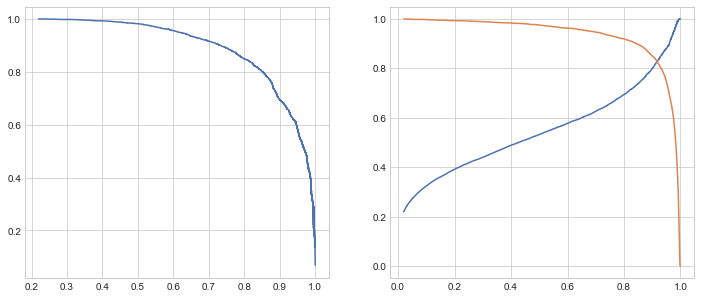

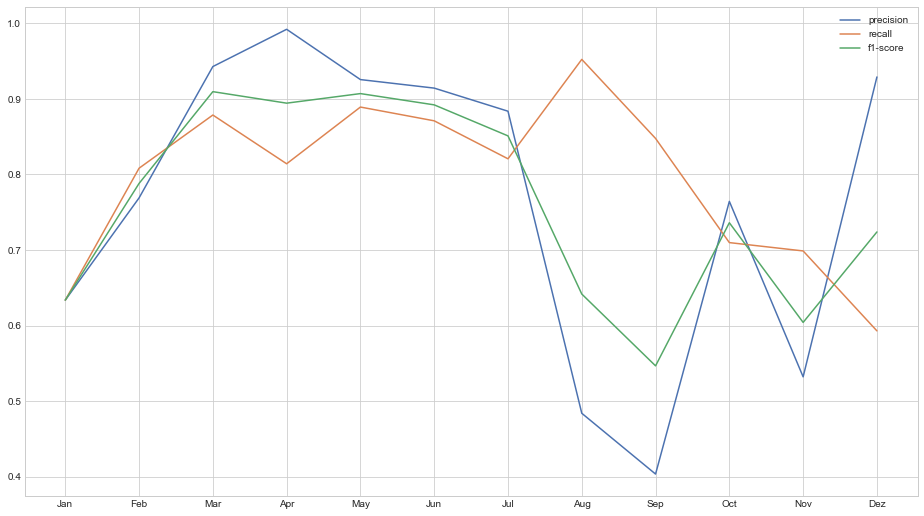

In [412]:
# model_CESMp = xgb.XGBClassifier(
#                     gamma=0.0,
#                     min_child_weight=0.0,
#                     max_delta_step=0.0,
#                     subsample=1.0,
#                     colsample_bytree=1.0,
#                     colsample_bylevel=1.0,
#                     verbosity=0,
#                     nthread=10,
#                     scale_pos_weight=20.0,
#                     base_score=0.2,
#                     seed=1337,
#                     missing=None,
#                   )

# parameters_CESMp = {'max_depth': [4], 'learning_rate': [0.1], 'n_estimators':[100], "reg_alpha":[10], "reg_lambda":[10] }
# best_model_CESMp, best_threshold_CESMp, df_CESMp_reduced_features= get_best_model_through_CV(model= model_CESMp, 
#                                                                   parameters_CV= parameters_CESMp, 
#                                                                   df = df_CESMp_reduced_features, 
#                                                                   feature_names = feature_names_reduced, 
#                                                                   target_variable="Foehn_CESMp")

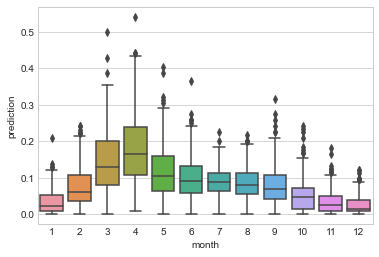

In [413]:
# df_CESMp_reduced_features["month"] = df_CESMp_reduced_features["date"].dt.month
# df_CESMp_reduced_features["year"] = df_CESMp_reduced_features["date"].dt.year
# df_monthly_mean_CESMp = df_CESMp_reduced_features[["date", "year", "month", "ensemble", "prediction"]].groupby(["ensemble", "year", "month"], axis=0, as_index=False).mean()

# fig = sns.boxplot(x="month", y="prediction", data=df_monthly_mean_CESMp)

# Concenate all dataframes

In [842]:
# Create dataframe for actually observed foehn cases 
df_foehn = df_ERA_reduced_features_scaled.loc[:, ["date", "Foehn"]]
df_foehn["dataset"] = "observed_foehn"
df_foehn["ensemble"] = "observed_foehn"
df_foehn.rename({"Foehn": "prediction"}, axis=1, inplace=True)

In [843]:
# Concat all observed foehn, ERAI, CESMp and CESMf prediction
df_foehn_ERA_CESMp_CESMf = pd.concat([df_foehn, 
                                      df_ERA_reduced_features_scaled, 
                                      df_CESMp_reduced_features_scaled, 
                                      df_CESMf_reduced_features_scaled], 
                                     axis=0, 
                                     ignore_index=True)

In [844]:
# Might be necessary to transform type of date column (should not)
# df_foehn_ERA_CESMp_CESMf["date"] = pd.to_datetime(df_foehn_ERA_CESMp_CESMf["date"], utc=True)

In [845]:
# Create month and year column
df_foehn_ERA_CESMp_CESMf["month"] = df_foehn_ERA_CESMp_CESMf["date"].dt.month
df_foehn_ERA_CESMp_CESMf["year"] = df_foehn_ERA_CESMp_CESMf["date"].dt.year

In [846]:
# Group dataframe by dataset, ensemble, year, month, and prediction and calculate mean
df_monthly_mean = df_foehn_ERA_CESMp_CESMf[["date", "year", "month", "dataset", "ensemble", "prediction"]].groupby(["dataset", "ensemble", "year", "month"], axis=0, as_index=False).mean()

In [847]:
# Retrieve the test period (1991 until 2000) and future prediction (2091-2100)
test_mask_final_plot = ((1980< df_monthly_mean["year"]) & (df_monthly_mean["year"]<2021)) | (2090< df_monthly_mean["year"])
df_monthly_mean_testset = df_monthly_mean[test_mask_final_plot]

# Create Plots

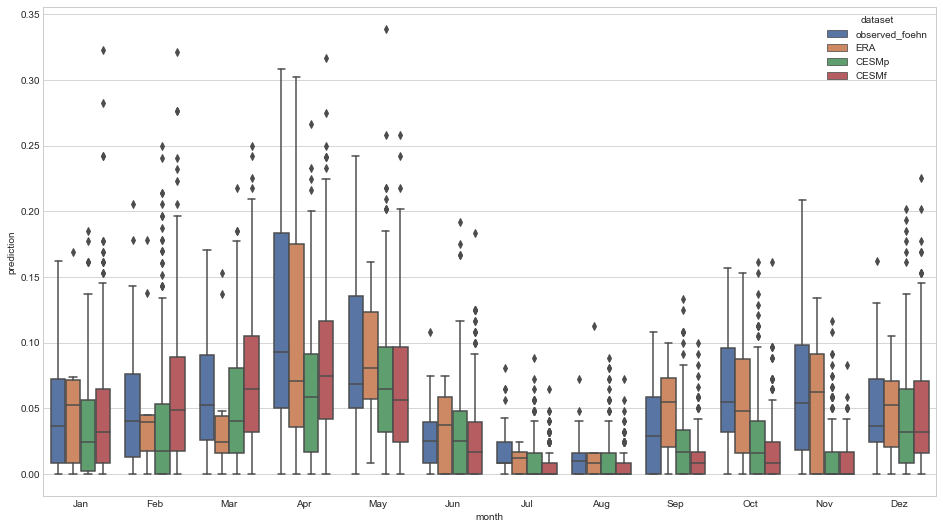

In [848]:
# Plot boxplot for mean foehn frequencies for all datasets
plt.figure(figsize=(16,9))
fig = sns.boxplot(x="month", y="prediction", data=df_monthly_mean_testset, hue="dataset", hue_order=["observed_foehn", "ERA", "CESMp", "CESMf"])
fig.set_xticklabels(MONTH_NAMES);

# Second statistical test

(0.0, 0.2)

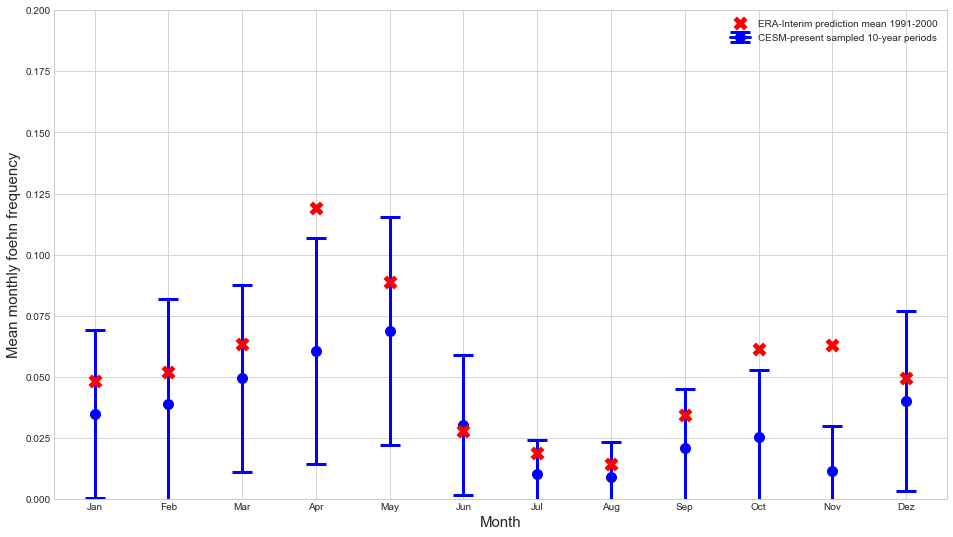

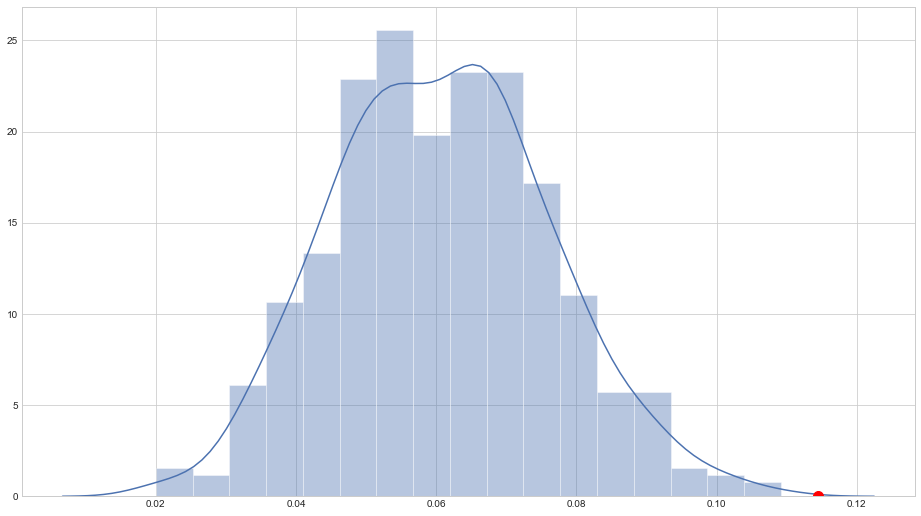

In [849]:
plt.figure(figsize=(16,9))
ax = plt.axes()

for month_test in range(1, 12+1):
    plt.figure(1)
    CESM_test_distribution = []
    df_CESMp_monthly = df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="CESMp") & (df_monthly_mean_testset["month"]==month_test),:].reset_index()
    for i in range(500):
        CESM_test_distribution_year = []
        for year in range(1991, 2001):
            CESM_test_distribution_year.append(df_CESMp_monthly.loc[df_CESMp_monthly["year"]==year, "prediction"].sample(1))
        CESM_test_distribution.append(np.mean(CESM_test_distribution_year))
#     if month_test == 2:
#         plt.errorbar(month_test, np.mean(np.array(CESM_test_distribution)), 
#                      yerr = np.array([[2.34*np.array(CESM_test_distribution).std(),3*np.array(CESM_test_distribution).std()]]).T, 
#                      color="b", 
#                      marker="o",
#                      markersize=10, 
#                      linewidth=3, 
#                      capsize=10, 
#                      capthick=3, 
#                      zorder=1)
#         plt.scatter(month_test, (df_sum.loc[(df_sum["original_dataset"]=="ERA") & (df_sum["month"]==month_test), "prediction"]).mean(), 
#                     marker="x", 
#                     color="r", 
#                     s=110, 
#                     linewidth=5, 
#                     zorder=10)
#     else:
    plt.errorbar(month_test, np.mean(np.array(CESM_test_distribution)), 
                 yerr = 3*np.array(CESM_test_distribution).std(), 
                 color="b", 
                 marker="o",
                 markersize=10, 
                 linewidth=3, 
                 capsize=10, 
                 capthick=3, 
                 zorder=1)
    plt.scatter(month_test, (df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="observed_foehn") & (df_monthly_mean_testset["month"]==month_test), "prediction"]).mean(), 
                marker="x", 
                color="r", 
                s=110, 
                linewidth=5, 
                zorder=10)

    if month_test==4:
        plt.figure(figsize=(16,9))
        sns.distplot(CESM_test_distribution)
        plt.plot(df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="ERA") & (df_monthly_mean_testset["month"]==month_test), "prediction"].mean(),0, 
                "ro", 
                markersize=10)
    
    if month_test==1: # To make plot prettier
        legend = ax.legend(["ERA-Interim prediction mean 1991-2000", "CESM-present sampled 10-year periods"])
        
ax.set(xticklabels=MONTH_NAMES, xticks=range(1,12+1))
ax.set_xlabel("Month",fontsize=15)
ax.set_ylabel("Mean monthly foehn frequency",fontsize=15)
ax.set_ylim((0,0.20))


# Third statistical test

In [808]:
for month_test in range(1, 12+1):
    CESMp_test_distribution = []
    CESMf_test_distribution = []
    df_CESMp_month = df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="CESMp") & (df_monthly_mean_testset["month"]==month_test),:].reset_index()
    df_CESMf_month = df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="CESMf") & (df_monthly_mean_testset["month"]==month_test),:].reset_index()
    st, p = sci.ks_2samp(df_CESMp_month["prediction"], df_CESMf_month["prediction"])

    print(MONTH_NAMES[month_test-1] +"\t" +str(np.round(p,5)) + "\t" + str(p<0.01))

Jan	0.12842	False
Feb	0.0	True
Mar	0.01634	False
Apr	0.03223	False
May	0.38342	False
Jun	0.21284	False
Jul	1e-05	True
Aug	0.0	True
Sep	0.0	True
Oct	0.0	True
Nov	0.18091	False
Dez	0.38342	False


# Ensemble deviation

Text(0, 0.5, 'Mean monthly foehn prediction')

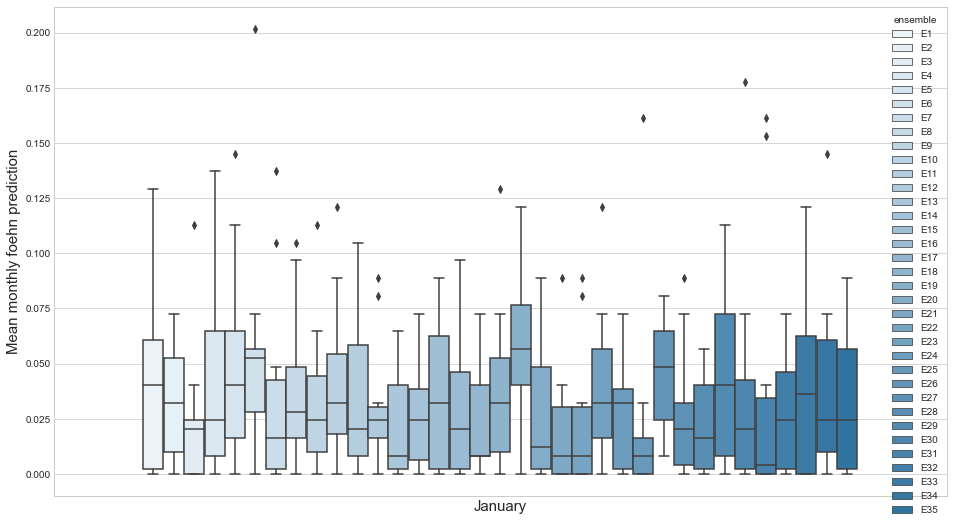

In [809]:
df_ensemble = df_foehn_ERA_CESMp_CESMf.loc[df_foehn_ERA_CESMp_CESMf["dataset"]=="CESMp"].groupby(["ensemble", "year", "month"], as_index=False).mean()

plt.figure(figsize=(16,9))
ax = sns.boxplot(x="month", y="prediction", data=df_ensemble.loc[df_ensemble["month"]==1,:], hue="ensemble", hue_order=["E"+str(i) for i in range(1,35+1)], color="tab:blue")

ax.set(xticks=[])
ax.set_xlabel("January",fontsize=15)
ax.set_ylabel("Mean monthly foehn prediction",fontsize=15)
# sns.set(font_scale=0.8)